### CodeAlong Värdes Regression (Value Regression)
- Value Regression på "mpg" datasetet från Seaborn. Kolla också E0-uppgiften.
- Datasetet innehåller data för olika bilar, såsom vikt, displacement, horsepower, förbrukning mm.
- X = Förklaringsvariabler, explanatory variables, oberoende variabler, independent variables
- y = Responsevariabel, dependent variable
- Uppgiften är att uppskatta förbrukningen, y
- i Uppgiften så gör vi först en vanlig multipel linjär regression, som vi sedan jämför med en lösning med ett grunt neuralt nätverk. Grunt betyder att det saknar hidden layers.
- 

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = sns.load_dataset('mpg').drop(columns=['name'], axis=1)

In [4]:
df = df.dropna() #droppar nan's
df = pd.get_dummies(df, columns=['origin'])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449,10.5,70,False,False,True


- Delar upp datan i X (förklaringsvariable) och y (responsvariabel).
- Delar upp datan i träningsdata och test data
- Standardiserar datan mha Standardscaler

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['mpg']).values, df['mpg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((274, 9), (118, 9))

#### Linjär regression:

In [6]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(scaled_X_train, y_train)
intercept = model_lr.intercept_
coef = model_lr.coef_
intercept, coef

(np.float64(23.637591240875913),
 array([-0.57077629,  2.12139619, -1.0951123 , -5.29418331,  0.11779671,
         2.81161879,  0.51720792,  0.60483405, -0.89525387]))

#### Shallow MLP approach:

In [7]:
import keras
from keras import layers
from keras.optimizers import SGD

inputs = keras.Input(shape=(X_train.shape[1],), name='input_layer') # input layer med 9 inputs
outputs = layers.Dense(1, name='output_layer')(inputs) # output layer med 1 output
model_shallow = keras.Model(inputs=inputs, outputs=outputs, name='shallow_model')

model_shallow.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error')
model_shallow.summary()

Model: "shallow_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

Tränar neurala nätverks modellen:

In [8]:
model_shallow.fit(scaled_X_train, y_train, epochs=50, verbose=0,
                  validation_data=(scaled_X_test, y_test))

Plottar träningshistoriken:

<Axes: xlabel='Epochs', ylabel='loss'>

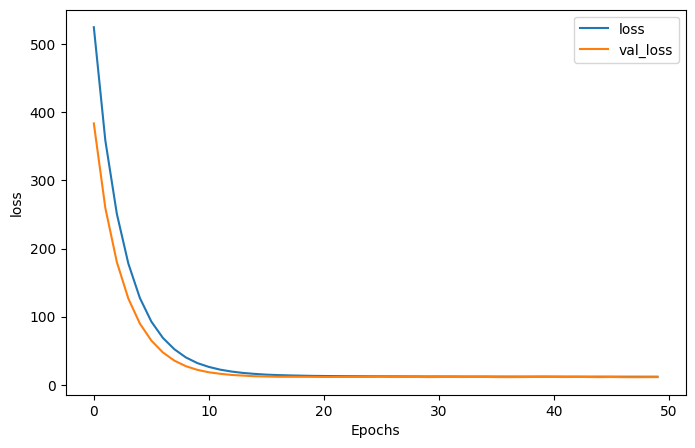

In [9]:
pd.DataFrame(model_shallow.history.history).plot(xlabel="Epochs", ylabel="loss",figsize=(8, 5))

In [10]:
weights, bias = model_shallow.layers[1].get_weights() # get the weights and bias from the model

Jämför weights (från MLP) med koefficienterna från linjära regressionen ovan:

In [11]:
weights, coef

(array([[-0.30045882],
        [-0.65144795],
        [-1.2418696 ],
        [-3.0627716 ],
        [-0.31825632],
        [ 2.6112592 ],
        [ 0.3445345 ],
        [ 0.5757518 ],
        [-0.72605914]], dtype=float32),
 array([-0.57077629,  2.12139619, -1.0951123 , -5.29418331,  0.11779671,
         2.81161879,  0.51720792,  0.60483405, -0.89525387]))

Jämför bias och intercept:

In [12]:
bias, intercept

(array([23.62316], dtype=float32), np.float64(23.637591240875913))

Beräknar  
MAE = Mean Absolute Error (medel absolut felet mellan prediktion och rätt värde)  
MSE = Mean Squared Error (medel felet i kvadrat mellan prediktionen och rätt värde)  
RMSE = Root Mean Squared Error (roten ur MSE)  
RMSE_prop = Root Mean Squared Error Proportional (RMSE normaliserat baserat på medel avstånd till target variabeln)  

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_regression(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mean_absolute_error(y_test, y_pred), mse, np.sqrt(mse)

y_pred_NN = model_shallow.predict(scaled_X_test)
y_pred_lr = model_lr.predict(scaled_X_test)

scores = {model: evaluate_regression(y_test, y_pred) for model, y_pred in zip(["NN", "LR"], [y_pred_NN, y_pred_lr])}

df_scores = pd.DataFrame(scores, index=["MAE", "MSE", "RMSE"]).T

df_scores["RMSE_prop"] = df_scores["RMSE"] / y_test.mean()

df_scores

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,MAE,MSE,RMSE,RMSE_prop
NN,2.604272,11.220157,3.349650,0.145632
LR,2.534490,10.344169,3.216235,0.139831
